[![preview notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PySDM/blob/main/examples/PySDM_examples/expansion_chamber/expansion_experiment.ipynb)
[![launch on mybinder.org](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=lab/tree/examples/PySDM_examples/expansion_chamber/expansion_experiment.ipynb)
[![launch on Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/expansion_chamber/expansion_experiment.ipynb)

modeling expansion-chamber experiments described in [Erinin et al. 2025](https://doi.org/10.48550/arXiv.2501.01467)

In [ ]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples')

In [1]:
import numpy as np
from matplotlib import pyplot
from open_atmos_jupyter_utils import show_plot
from PySDM import Formulae
from PySDM.physics import si

from PySDM_examples.Erinin_et_al_2025.aerosol import AerosolChamber
from PySDM_examples.Erinin_et_al_2025.expansion_simulation import run_expansion

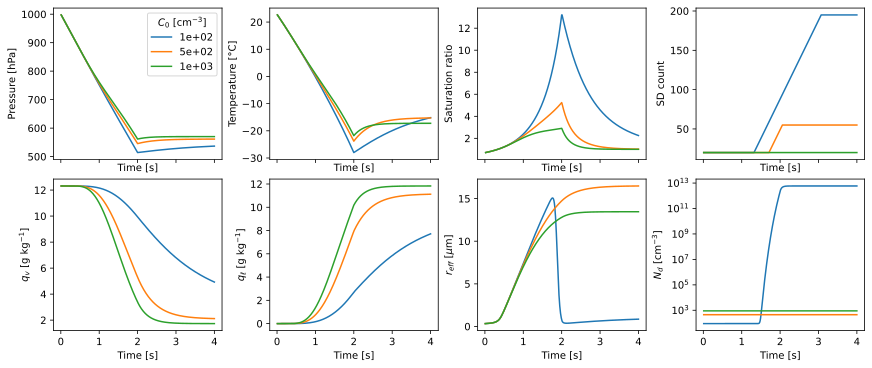

HTML(value="<a href='./C0_sweep_traces.pdf' target='_blank'>./C0_sweep_traces.pdf</a><br>")

In [2]:
n_sd_per_mode = 20
DT = .01 * si.s

variables = ["p", "T", "s", "sd_count", "water_vapour_mixing_ratio", "liquid_water_mixing_ratio", "reff", "n_drop"]
offsets = [0, -273.15, 1, 0, 0, 0, 0, 0]
factors = [1/100, 1, 1, 1, 1, 1, 1, 1]
ylabels = ["Pressure [hPa]", "Temperature [°C]", "Saturation ratio", "SD count",
           "$q_v$ [g kg$^{-1}$]", "$q_\ell$ [g kg$^{-1}$]", "$r_{eff}$ [$\mu$m]", "$N_d$ [cm$^{-3}$]"]
fig,axes=pyplot.subplots(2,4,figsize=(12,5),sharex=True,sharey=False,constrained_layout=True)

for Na in [1e2, 5e2, 1e3]: #[1, 10, 100, 1000, 10000, 100000]:

    formulae = Formulae(
        adiabatic_exponent="MoistLeadingTerms",
        homogeneous_liquid_nucleation_rate='CNT',
    )
    const = formulae.constants
    aerosol = AerosolChamber(
            water_molar_volume=const.Mv / const.rho_w,
            N=Na / si.cm**3,
        )

    output = run_expansion(formulae, aerosol, n_sd_per_mode, n_sd_homo_liq_nucleation=200, total_time=4*si.s, dt=DT)
    
    for i,ax in enumerate(axes.flatten()):
        y = np.array(output.profile[variables[i]]) * factors[i] + offsets[i]
        ax.plot(output.profile["t"], y, label=f"{Na:.0e}")
        if i == 7:
            ax.set_yscale("log")
        ax.set_xlabel("Time [s]")
        ax.set_ylabel(ylabels[i])

axes[0,0].legend(title="$C_0$ [cm$^{-3}$]")
show_plot("C0_sweep_traces.pdf")

In [ ]:
n_sd_per_mode = 20

p0 = 1000 * si.hPa
dp = np.insert(np.linspace(100,600,11),0,1) * si.hPa
Tmin = np.zeros_like(dp)
Smax = np.zeros_like(dp)
Tmin_clean = np.zeros_like(dp)
Smax_clean = np.zeros_like(dp)
Tmin_dry = np.zeros_like(dp)
Smax_dry = np.zeros_like(dp)
for i,dpi in enumerate(dp):
    print(i,dpi)

    formulae = Formulae()
    const = formulae.constants
    aerosol = AerosolChamber(water_molar_volume=const.Mv / const.rho_w, N=2000 / si.cm**3)
    output = run_expansion(formulae, aerosol, n_sd_per_mode, RH0=0.5, p0=p0, pf=(p0 - dpi), dt=DT)
    Tmin[i] = np.nanmin(output.profile["T"]) - 273.15 # °C
    Smax[i] = np.nanmax(output.profile["s"]) + 1 # saturation ratio

    aerosol = AerosolChamber(water_molar_volume=const.Mv / const.rho_w, N=1 / si.cm**3)
    output = run_expansion(formulae, aerosol, n_sd_per_mode, RH0=0.5, p0=p0, pf=(p0 - dpi), dt=DT)
    Tmin_clean[i] = np.nanmin(output.profile["T"]) - 273.15 # °C
    Smax_clean[i] = np.nanmax(output.profile["s"]) + 1 # saturation ratio

    output = run_expansion(formulae, aerosol, n_sd_per_mode, RH0=0, p0=p0, pf=(p0 - dpi), dt=DT)
    Tmin_dry[i] = np.nanmin(output.profile["T"]) - 273.15 # °C
    Smax_dry[i] = np.nanmax(output.profile["s"]) + 1 # saturation ratio

print(dp)
print(Tmin)
print(Tmin_clean)
print(Tmin_dry)

In [ ]:
print("p0 =",p0,"Pa")
print("T0 =",296-273.15,"°C")
print("dp =",dp)
print("Tmin (S0=0.5, C0=2000) =", Tmin)
print("Tmin (S0=0.5, C0=1) =", Tmin_clean)
print("Tmin (S0=0, C0=1) =", Tmin_dry)

In [ ]:
fig,ax = pyplot.subplots(1,1,figsize=(5,4))
ax.plot(dp/p0, Tmin_dry, color="black", marker="o", ls="--", label="$S_0 = 0, C_0 = 1 $ cm$^{-3}$")
ax.plot(dp/p0, Tmin_clean, color="turquoise", marker="o", ls="--", label="$S_0 = 0.5, C_0 = 1 $ cm$^{-3}$")
ax.plot(dp/p0, Tmin, color="green", marker="o", ls="--", label="$S_0 = 0.5, C_0 = 2000$ cm$^{-3}$")
ax.set_xlabel(r"$\Delta p / p_i$")
ax.set_ylabel(r"$T_{min}$ [°C]")
ax.legend(loc=3, frameon=False)
ax.set_title("PySDM parcel simulation, no homogeneous nucleation")
show_plot("Tmin_dp.pdf")

#########

fig,axes = pyplot.subplots(2,1,figsize=(6,6),sharex=True)

ax = axes[0]
ax.plot(dp/p0, Tmin_dry, color="black", marker="o", ls="--", label="$S_0 = 0, C_0 = 1 $ cm$^{-3}$")
ax.plot(dp/p0, Tmin_clean, color="turquoise", marker="o", ls="--", label="$S_0 = 0.5, C_0 = 1 $ cm$^{-3}$")
ax.plot(dp/p0, Tmin, color="green", marker="o", ls="--", label="$S_0 = 0.5, C_0 = 2000$ cm$^{-3}$")
ax.set_ylabel(r"$T_{min}$ [°C]")
ax.legend(loc=3, frameon=False)
ax.set_title("PySDM parcel simulation, no homogeneous nucleation")

ax = axes[1]
ax.plot(dp/p0, Smax_dry, color="black", marker="o", ls="--", label="$S_0 = 0, C_0 = 1 $ cm$^{-3}$")
ax.plot(dp/p0, Smax_clean, color="turquoise", marker="o", ls="--", label="$S_0 = 0.5, C_0 = 1 $ cm$^{-3}$")
ax.plot(dp/p0, Smax, color="green", marker="o", ls="--", label="$S_0 = 0.5, C_0 = 2000$ cm$^{-3}$")
ax.set_xlabel(r"$\Delta p / p_i$")
ax.set_ylabel(r"$S_{max}$")
# ax.set_yscale("log")
ax.set_ylim(-0.5,6)
ax.axhline(0, color="k", lw=0.5)
ax.axhline(1, color="k", lw=0.5)
ax.axhline(4, color="k", lw=0.5)

show_plot("dp_sweep.pdf")